In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
import graphviz
from sklearn.preprocessing import LabelEncoder

In [2]:
# Load the dataframe
df = pd.read_csv('DOHMH_New_York_City_Restaurant_Inspection_Results.csv', delimiter=',')
df.head(1)

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE
0,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,06/15/2015,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140Âº F.,Critical,30.0,NaN,NaN,08/28/2017,Cycle Inspection / Initial Inspection


Describe the Data

In [3]:
df.describe(include=[np.object])


,DBA,BORO,BUILDING,STREET,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE
count,399559,399918,399809,399909,399913,399918,399918,398783,393414,392939,399918,195413,192820,399918,398783
unique,20936,6,7256,3328,25165,84,1414,5,97,93,3,6,1325,1,34
top,DUNKIN' DONUTS,MANHATTAN,0,BROADWAY,7186566210,American,01/01/1900,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Critical,A,08/24/2016,08/28/2017,Cycle Inspection / Initial Inspection
freq,4296,159574,2372,14791,240,90968,1135,380632,55785,55785,220082,154194,455,399918,230431


Plotted the grades divided by boros

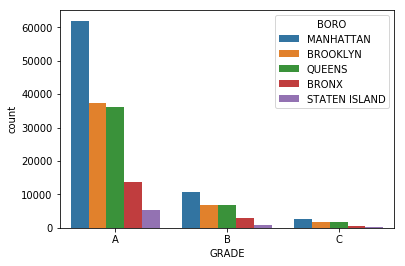

In [4]:
grades = df[df['GRADE'].isin(['A','B', 'C'])]
#grades['GRADE'].value_counts()
ax = sns.countplot(x='GRADE', hue='BORO', data=grades, order=grades['GRADE'].value_counts().index, hue_order=grades['BORO'].value_counts().index)

Plotted the average scores by boro

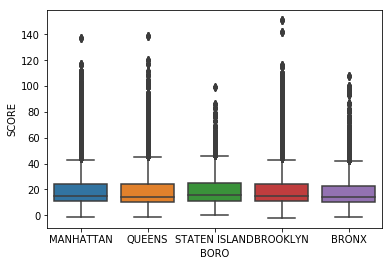

In [5]:
df['SCORE'].dropna()
boros = df[df['BORO'] != 'Missing']
ax = sns.boxplot(x='BORO', y='SCORE', data=boros)


Look at the violations by season

Change the date fromat
Some dates are recorded wrongly, the inspections start on Jan 1, 2010.
All dates with a date earlier than Jan 1, 2010 have been dropped since there is no date that could be used to replace it.

In [ ]:
df['INSPECTION DATE'] = pd.to_datetime(df['INSPECTION DATE'])
df[df['INSPECTION DATE'] > '2009-12-31']
df['MONTH']=pd.DatetimeIndex(df['INSPECTION DATE']).month
season_dict = {}
for month in range(1,13):
    if month > 2 and month < 6:
        season_dict[month] = 'Spring'
    elif month > 2 and month < 9:
        season_dict[month] = 'Summer'
    elif month > 2 and month < 12:
        season_dict[month] = 'Fall'
    else:
        season_dict[month] = 'Winter'

df['SEASON'] = df['MONTH'].map(season_dict)

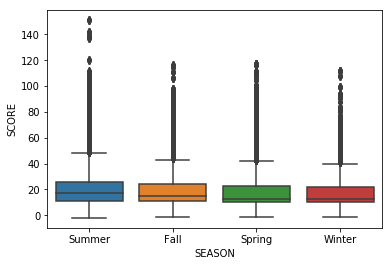

In [34]:
ax = sns.boxplot(x='SEASON', y='SCORE', data=df )

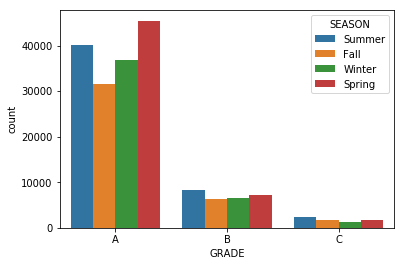

In [38]:
grades_by_seas = df[df['GRADE'].isin(['A','B', 'C'])]
ax = sns.countplot(x='GRADE', hue='SEASON', data=grades_by_seas, order=grades_by_seas['GRADE'].value_counts().index)